In [16]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import itertools
import matplotlib.image as mpimg


p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [2]:
config_file = '../snakemake/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
ab = '../'+expand(config['data']['ab'], species='human')[0]
filt_ab = '../'+expand(config['data']['filt_ab'], species='human')[0]
read_annot = '../'+expand(config['data']['read_annot'], species='human')[0]
t_metadata = '../'+expand(config['ref']['cerberus']['t_info'], species='human')[0]
lib_meta = '../'+expand(config['data']['meta'], species='human')[0]
swan_file = '../'+expand(config['data']['sg'], species='human')[0]
cerberus_h5 = '../'+expand(config['data']['cerb_annot'], species='human')[0]
cerb_t_metadata = '../'+expand(config['data']['t_info'], species='human')[0]
major_isos = '../'+expand(config['data']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = '../'+expand(config['data']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]
pp_summary = '../'+expand(config['data']['p_pred']['summary'], species='human')[0]
ref_t_metadata = '../'+expand(config['ref']['t_info'], species='human')[0]
ref_g_metadata = '../'+expand(config['ref']['g_info'], species='human')[0]


ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'polya'
obs_col = 'sample'
go_gene_subset = 'protein_coding'
predom_iso_subset = 'protein_coding'

m_lib_meta = '../'+expand(config['data']['meta'], species='mouse')[0]

In [4]:
sns.set_context('paper', font_scale=1.8)
c_dict, order = get_biosample_colors()

In [5]:
ab_df = pd.read_csv(filt_ab, sep='\t')
df, tids = get_tpm_table(ab_df,
               how='iso',
               min_tpm=min_tpm,
               gene_subset=gene_subset)
det_df = get_det_table(ab_df,
               how='iso',
               min_tpm=min_tpm,
               gene_subset=gene_subset)

Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/utils.py:2096: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/utils.py:2095: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 231136
# isos >= 1 tpm: 210239
Applying gene type and novelty subset
Number of isos reported: 206806
Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 231136
# isos >= 1 tpm: 210239
Applying gene type and novelty subset
Number of isos reported: 206806
Found 138 total libraries


In [6]:
# get all pairwise sets of tech reps
meta_df = pd.read_csv(lib_meta, sep='\t')
meta_df['biorep'] = meta_df['dataset'].str.rsplit('_', n=1, expand=True)[0]

all_pairs = []
for b in meta_df['biorep'].unique().tolist():
    b_datasets = meta_df.loc[meta_df.biorep==b, 'dataset'].tolist()
    pairs = list(itertools.combinations(b_datasets, 2))
    all_pairs += pairs

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1690: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


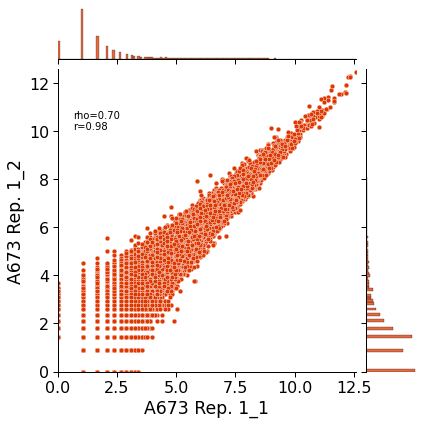

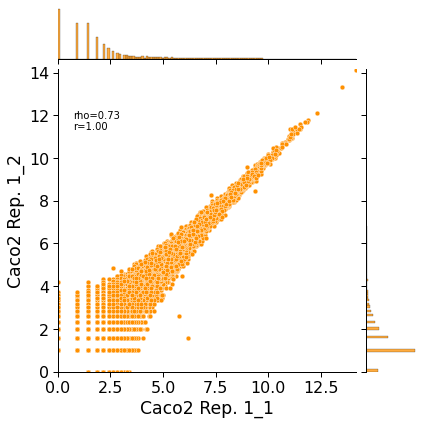

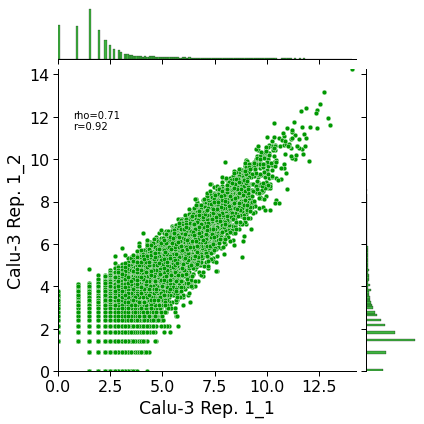

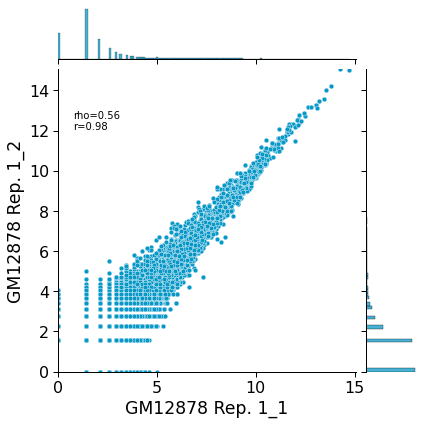

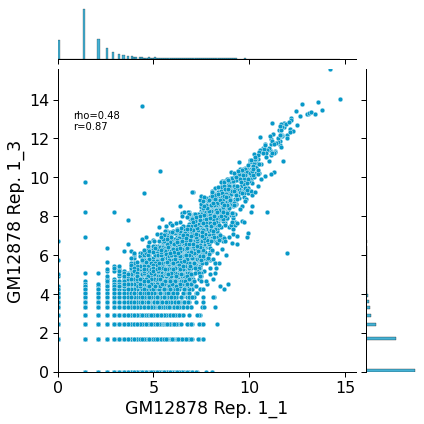

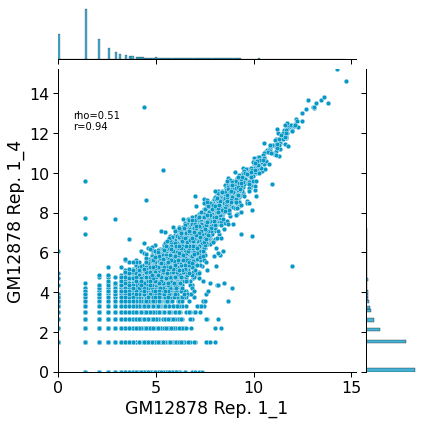

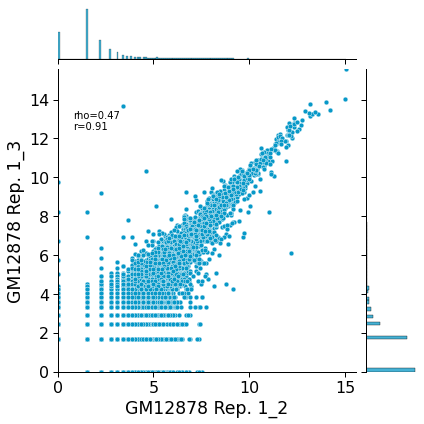

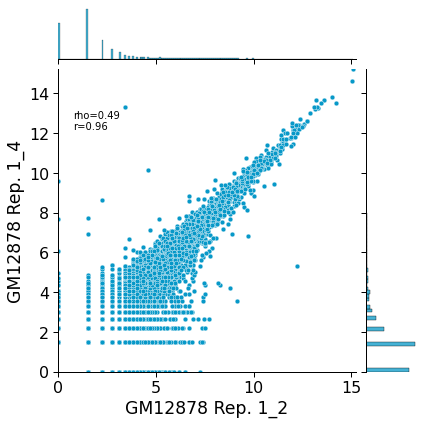

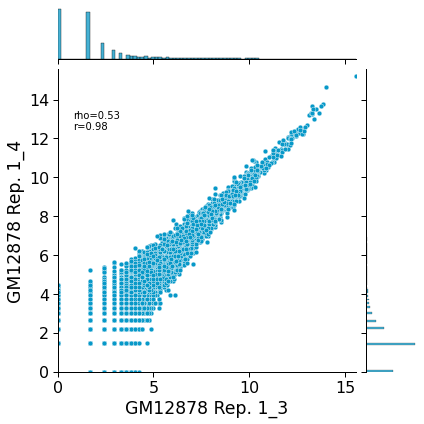

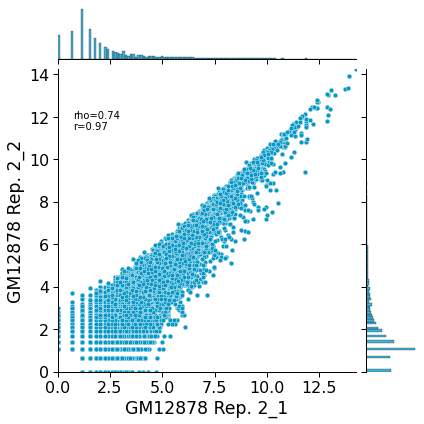

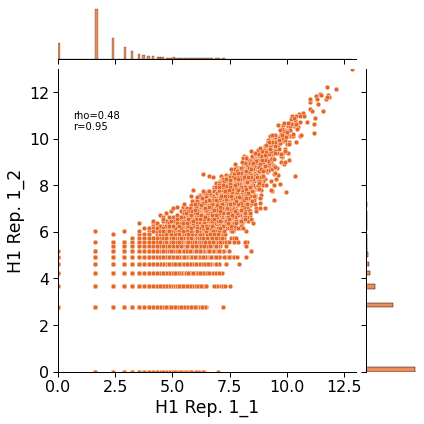

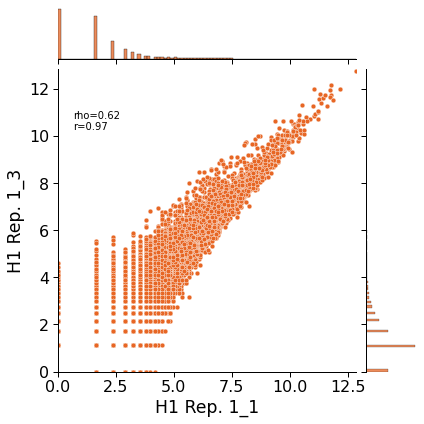

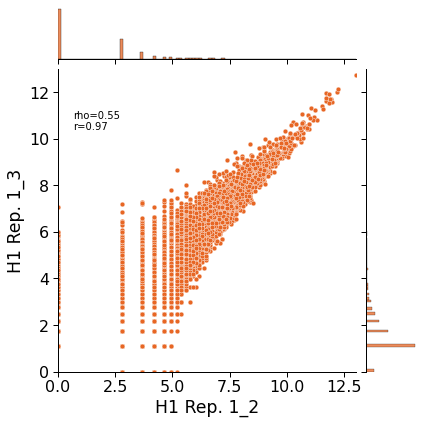

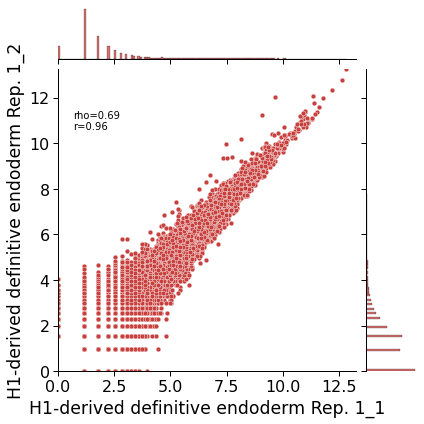

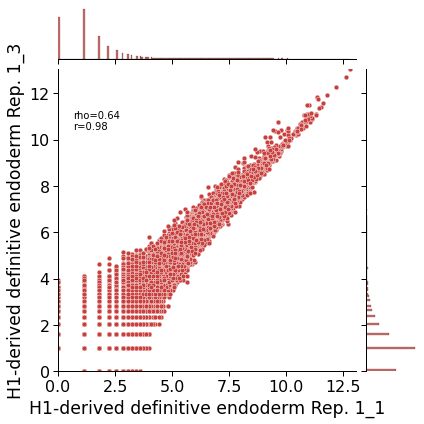

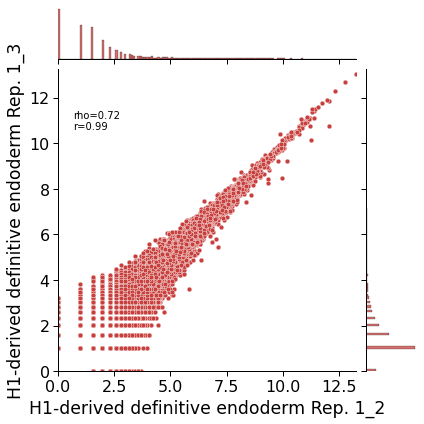

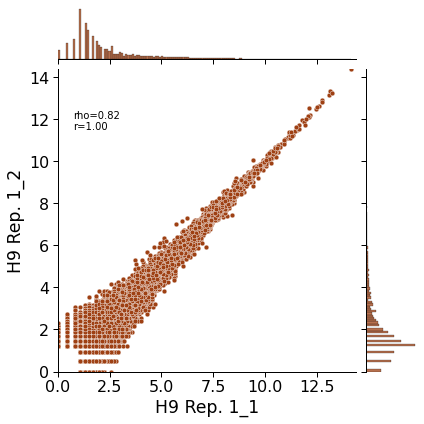

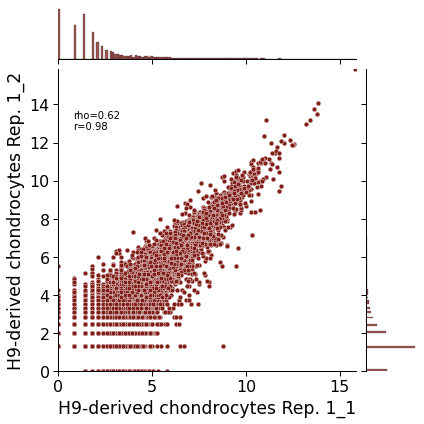

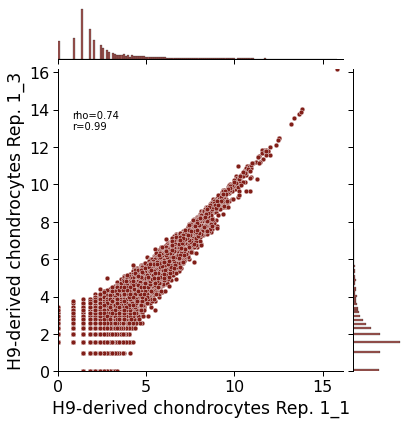

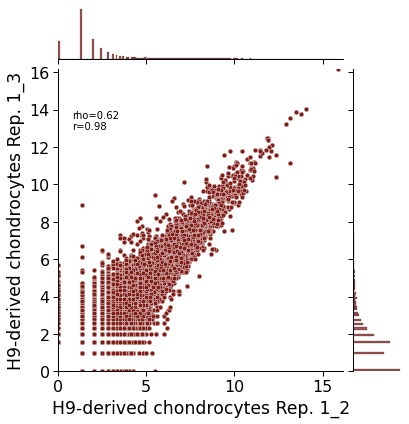

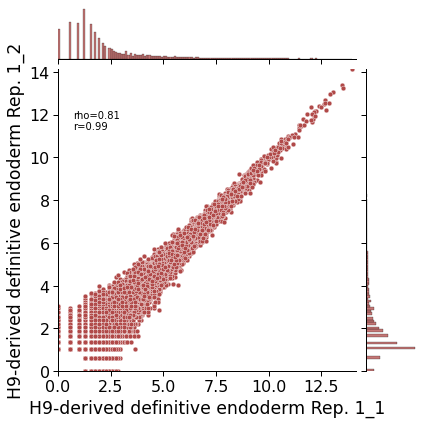

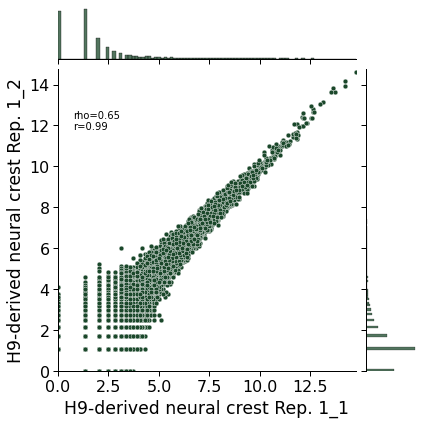

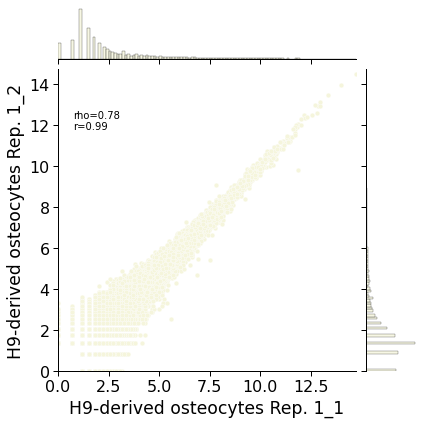

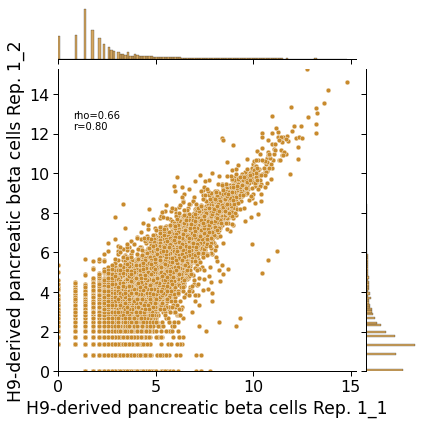

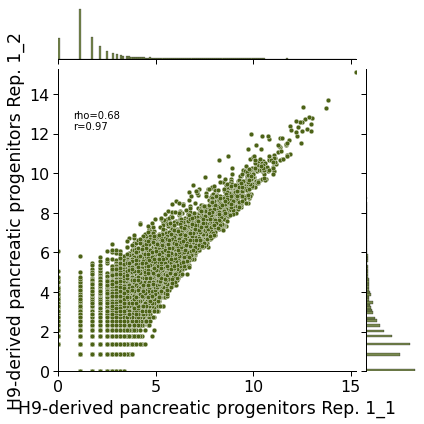

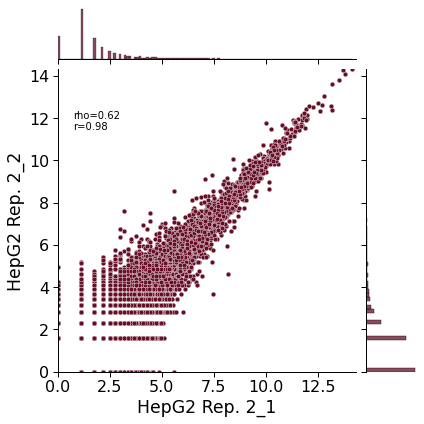

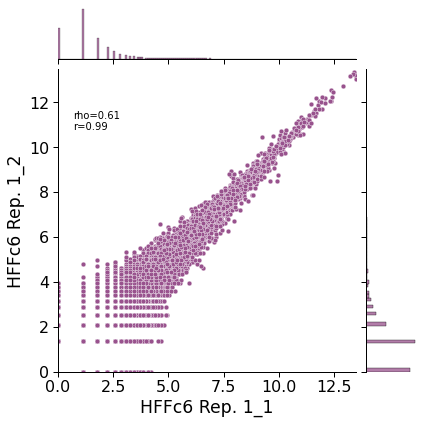

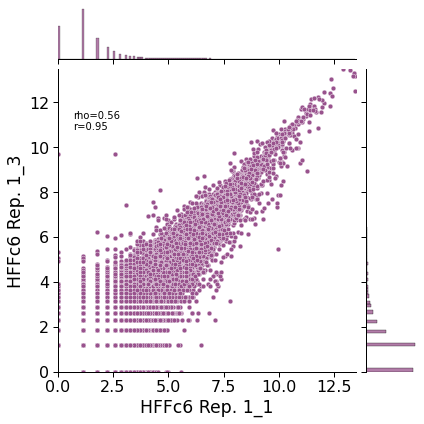

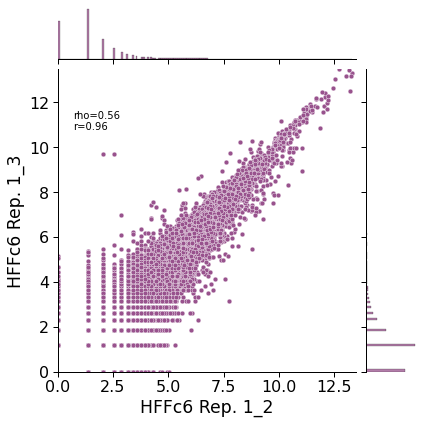

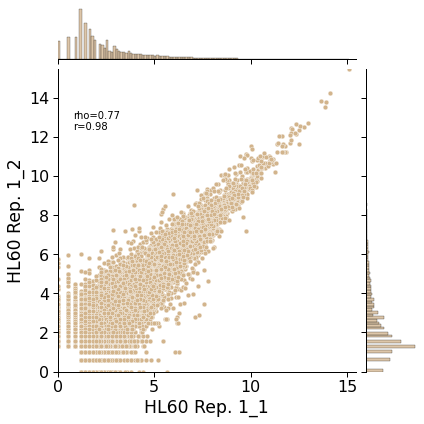

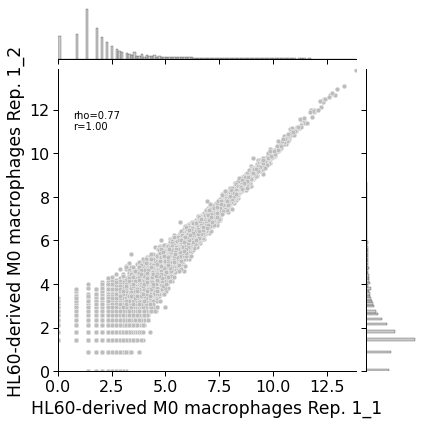

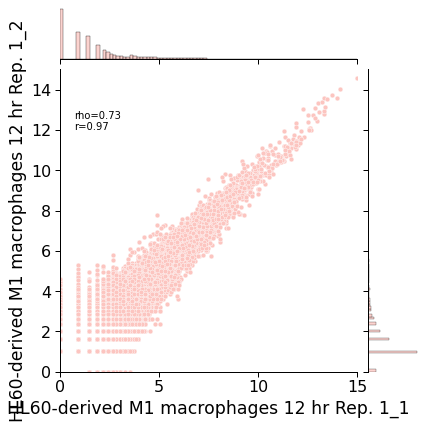

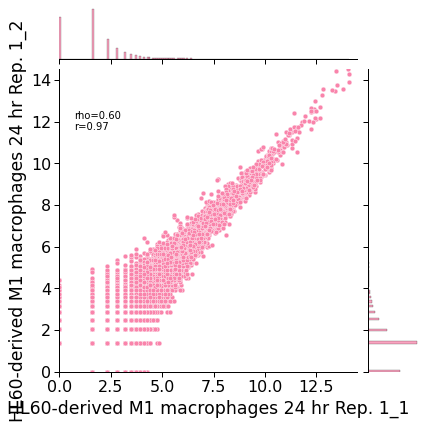

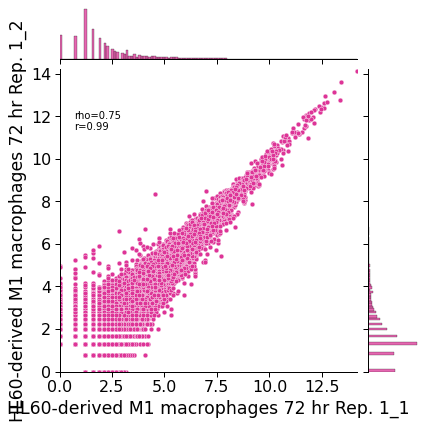

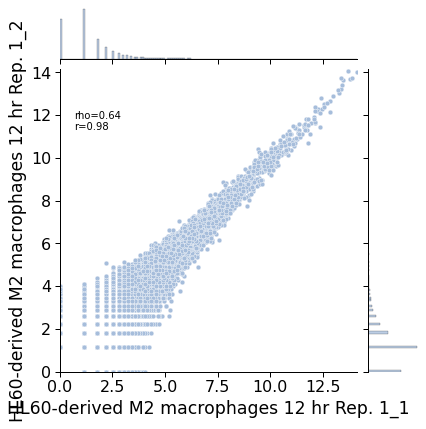

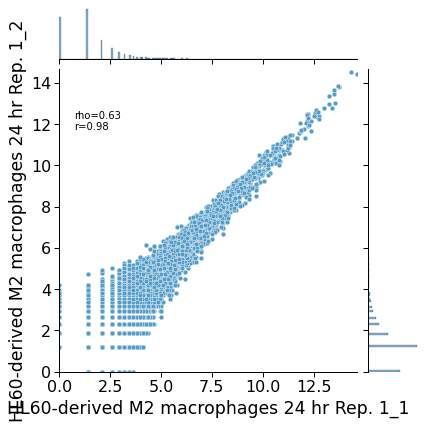

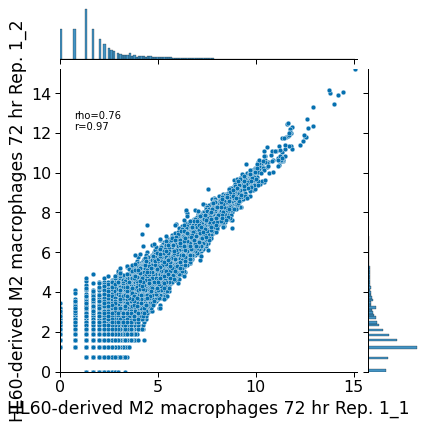

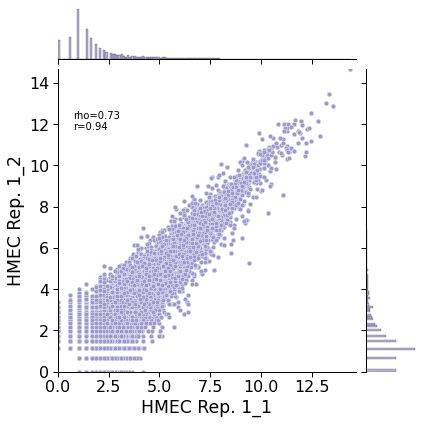

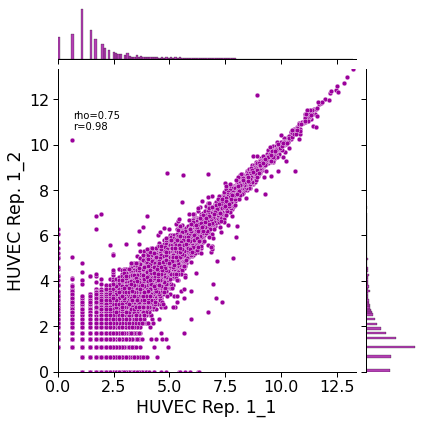

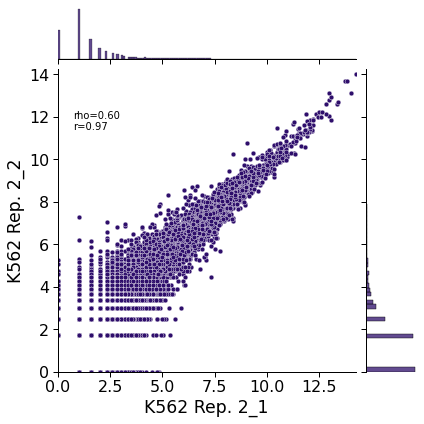

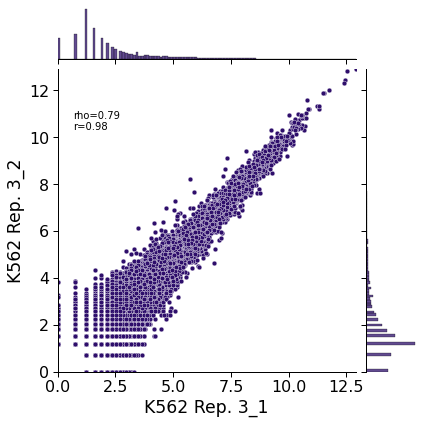

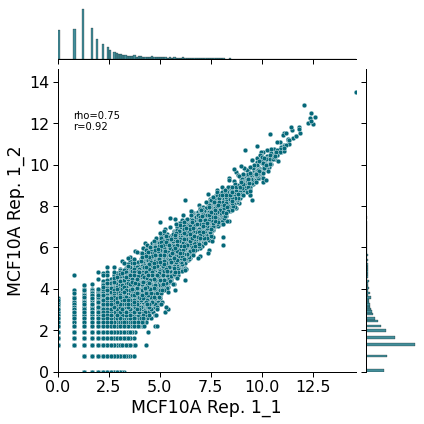

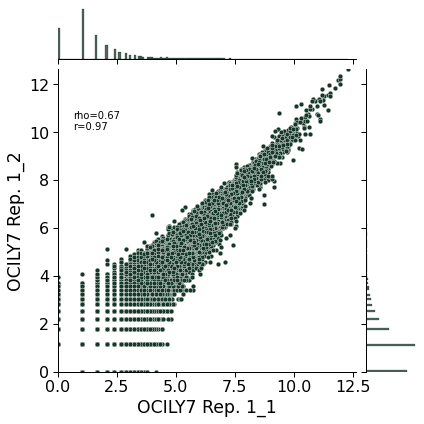

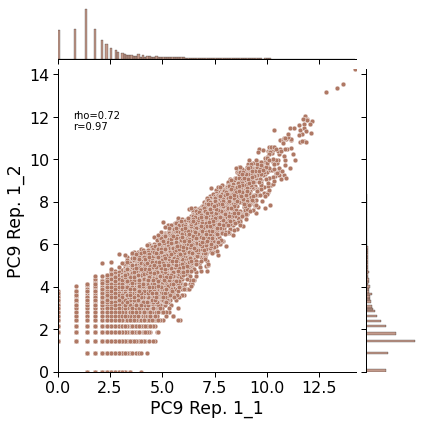

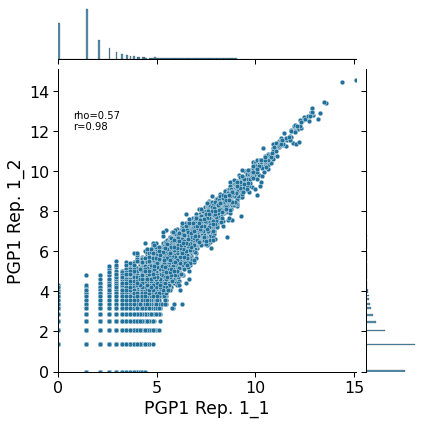

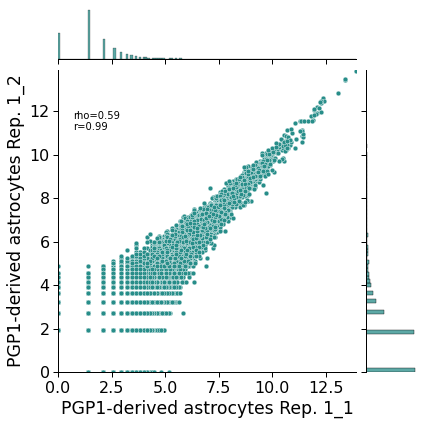

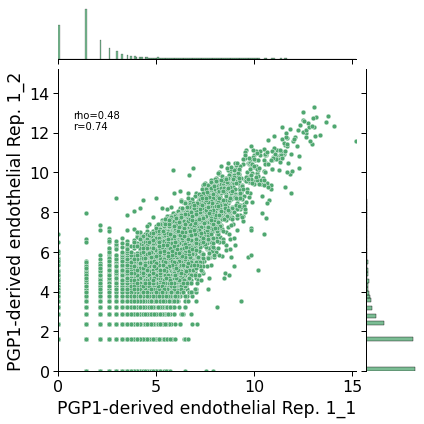

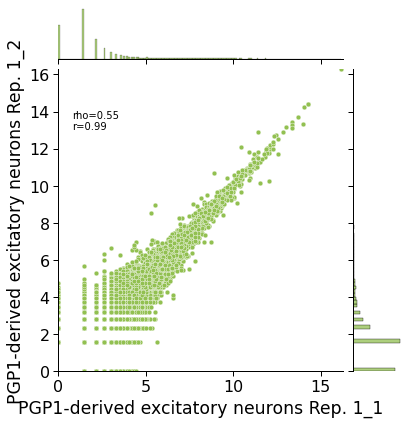

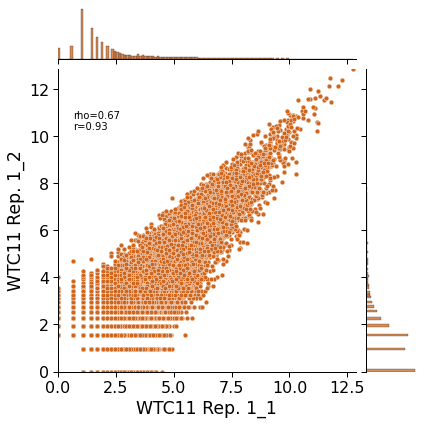

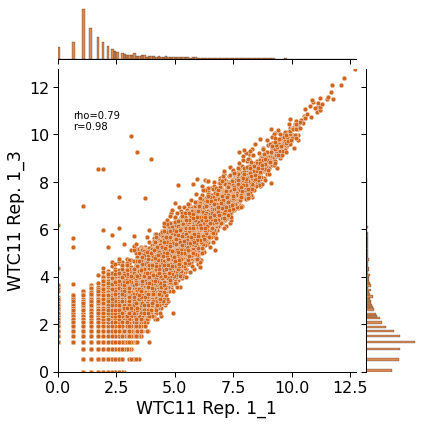

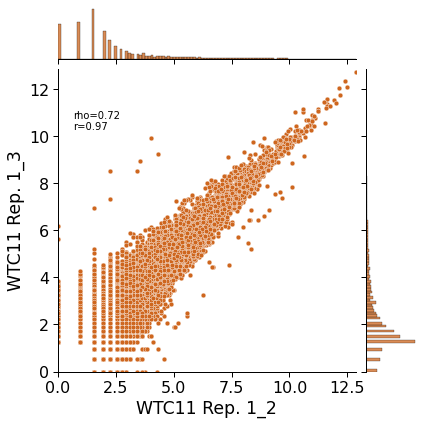

In [39]:
fnames = []
for i, p in enumerate(all_pairs):
    sample = p[0].rsplit('_', 2)[0]
    x = p[0]
    y = p[1]
    
    temp = df[[x, y]].copy(deep=True)
    
    # remove transcripts expressed >1 TPM
    temp_det = det_df.transpose()[[x, y]].copy(deep=True)
    det_tids = temp_det.loc[temp_det.any(axis=1)].index.tolist()
    temp = temp.loc[det_tids]

    rho, p = st.spearmanr(temp[x].tolist(), temp[y].tolist())
    r, p2 = st.pearsonr(temp[x].tolist(), temp[y].tolist())
    
    # add pseudocounts and plot log2tpm
    temp = temp+1
    temp = np.log2(temp)
    lim = (0, max(temp[x].max(), temp[y].max()))
    g = sns.jointplot(temp, x=x, y=y, color=c_dict[sample],
                      ylim=lim, xlim=lim) 
    for d, ax in zip([x,y], ['x','y']):
        label = meta_df.loc[meta_df.dataset==d, 'sample_display'].values[0]
        label += f" Rep. {'_'.join(d.rsplit('_',2)[-2:])}"
        if ax == 'x':
            g.ax_joint.set_xlabel(label)
        elif ax == 'y':
            g.ax_joint.set_ylabel(label)
    plt.text(.05, .8, 'rho={:.2f}\nr={:.2f}'.format(rho,r), transform=g.ax_joint.transAxes)
    fname = f'{i}.png'
    plt.savefig(fname)
    fnames.append(fname)
    # plt.close(g)

51


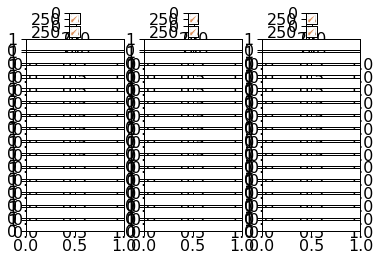

In [42]:
f, axarr = plt.subplots(17, 3, squeeze=True)
axs = []
for i in range(axarr.shape[0]):
    for j in range(axarr.shape[1]):
        axs.append(axarr[i][j])
print(len(axs))
for i, f in enumerate(fname):
    axs[i].imshow(mpimg.imread(fname))
plt.show()